In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import fp_fft

## Demonstrating RFI/Overflow Behavior

Here, we put in a DC tone and observe how an insufficiently aggressive shift schedule causes that tone to overflow an intermediate butterfly stage, leaking that tone into other bins. An overflow error has the characteristic of always adding power to other bins at the expense of power in the primary (correct) bin. To whit, they are stalagmites.

In [2]:
# Create a (floating-point) signal input
NSTAGES = 12
NCHAN = 2**NSTAGES
signal = (np.random.normal(size=NCHAN) + 1j * np.random.normal(size=NCHAN)) / 80 # noise
signal += 0.125 # dc signal

In [3]:
# Digitize the input signal according to the specified fixed point type
fpt = fp_fft.FixedPointType(18, 17)
sig_real = fpt.from_float(signal.real)
sig_imag = fpt.from_float(signal.imag)

### Accuracy of digitized version of input signal

<IPython.core.display.Javascript object>


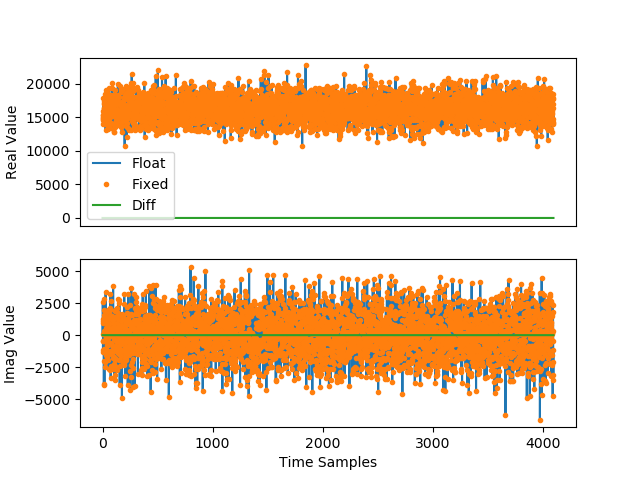

In [4]:
plt.figure()
plt.subplot(211)
plt.plot(signal.real * 2**fpt.bin_point, label='Float')
plt.plot(sig_real, '.', label='Fixed')
plt.plot(signal.real * 2**fpt.bin_point - sig_real, label='Diff')
plt.legend(loc='best')
plt.ylabel('Real Value')
plt.xticks([])
plt.subplot(212)
plt.plot(signal.imag * 2**fpt.bin_point, label='Float')
plt.plot(sig_imag, '.', label='Fixed')
plt.plot(signal.imag * 2**fpt.bin_point - sig_imag, label='Diff')
plt.ylabel('Imag Value')
_ = plt.xlabel('Time Samples')

### Comparing FFT Outputs

Now we will compare a fixed-point FFT with two different shift schedules (one sufficient to avoid overflow, the other not) to a floating-point FFT that is the standard for accuracy.

In [5]:
shifts1 = [1] * NSTAGES       # A sufficiently aggressive shift schedule
shifts2 = [0, 1, 0, 1] * 3 # An insufficiently aggressive shift schedule
_signal = np.fft.fft(signal) * 2**fpt.bin_point / 2**sum(shifts2)
_sig1_real, _sig1_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts1)
_sig2_real, _sig2_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts2)
_sig1_real *= 2**(sum(shifts1) - sum(shifts2))
_sig1_imag *= 2**(sum(shifts1) - sum(shifts2))
#_diff = np.fft.fft(signal * 2**fpt.bin_point - sig_real - 1j*sig_imag) / 2**sum(shifts)

<IPython.core.display.Javascript object>


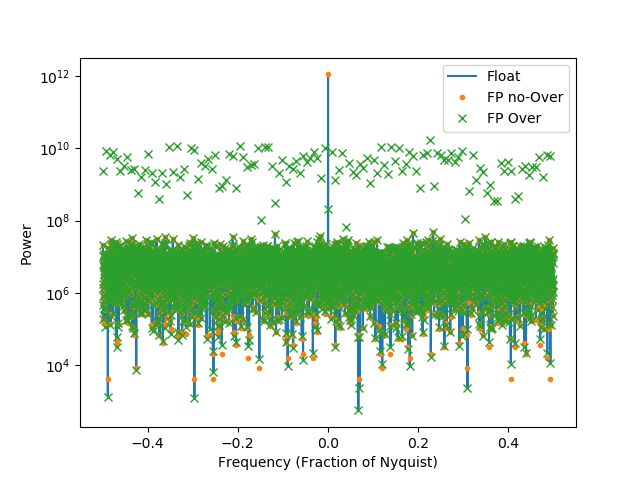

In [6]:
freq = np.fft.fftfreq(NCHAN)
_signal_power = np.abs(_signal)**2
_sig1_power = _sig1_real.astype(np.int64)**2 + _sig1_imag.astype(np.int64)**2
_sig2_power = _sig2_real.astype(np.int64)**2 + _sig2_imag.astype(np.int64)**2
#_diff_power = np.abs(_diff)**2
plt.figure()
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_signal_power), label='Float')
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_sig1_power), '.', label='FP no-Over')
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_sig2_power), 'x', label='FP Over')
plt.xlabel('Frequency (Fraction of Nyquist)')
plt.ylabel('Power')
_ = plt.legend(loc='best')
#plt.semilogy(np.fft.fftshift(np.abs(_signal_power - _sig_power)), '.-')
#plt.semilogy(np.fft.fftshift(_diff_power), '.')

<IPython.core.display.Javascript object>


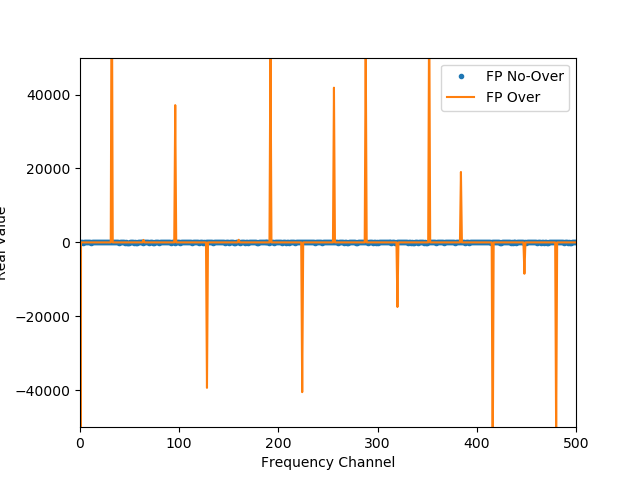

In [7]:
plt.figure()
plt.plot(_sig1_real - _signal.real, '.', label='FP No-Over')
plt.plot(_sig2_real - _signal.real, label='FP Over')
plt.legend(loc='best')
plt.ylim(-5e4, 5e4)
plt.xlim(0,500)
plt.ylabel('Real Value')
_ = plt.xlabel('Frequency Channel')

The repeated devation of the overflow every $2^5$ channels tells us that the 5th stage of the fixed-point FFT overflowed.

## Attempting to Create Icicles

The overflow errors shown above can only leak power from one channel into others; it cannot explaing the "missing power" (a.k.a. "icicles" or "stalactites") problem in the HERA 3C correlator. To make that happen, we need to invoke a different problem.

### Attempt 1: Input Comb of missing samples

In order to lose power, we need to lose samples. Knowing that the FT of a comb is a comb, my first guess is that an input comb of missing samples might be able to explain icicles.

In [8]:
# Create a (floating-point) signal input
NTIMES = 1024
NSTAGES = 12
NCHAN = 2**NSTAGES
signal = (np.random.normal(size=(NTIMES,NCHAN)) + 1j * np.random.normal(size=(NTIMES,NCHAN))) / 80 # noise
signal += 0.125 # dc signal
# Create the comb
signal_comb = signal.copy()
signal_comb.shape = (NTIMES, 8, -1)
signal_comb[...,0] = 0
signal_comb.shape = (NTIMES, NCHAN)
# Digitize the input signal according to the specified fixed point type
fpt = fp_fft.FixedPointType(18, 17)
sig_real = fpt.from_float(signal_comb.real)
sig_imag = fpt.from_float(signal_comb.imag)

<IPython.core.display.Javascript object>


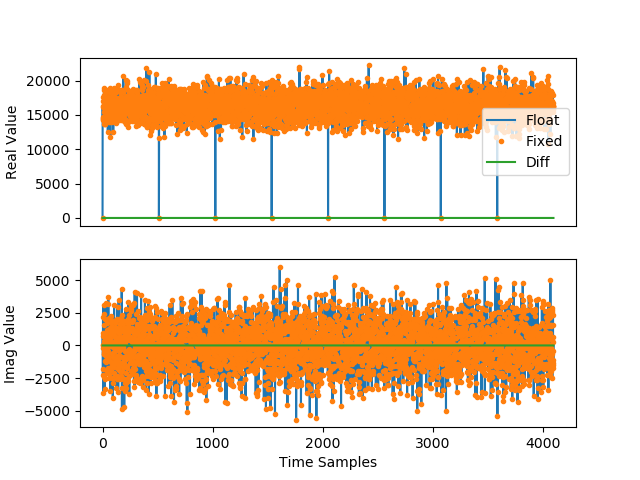

In [9]:
plt.figure()
plt.subplot(211)
plt.plot(signal_comb[0].real * 2**fpt.bin_point, label='Float')
plt.plot(sig_real[0], '.', label='Fixed')
plt.plot(signal_comb[0].real * 2**fpt.bin_point - sig_real[0], label='Diff')
plt.legend(loc='best')
plt.ylabel('Real Value')
plt.xticks([])
plt.subplot(212)
plt.plot(signal_comb[0].imag * 2**fpt.bin_point, label='Float')
plt.plot(sig_imag[0], '.', label='Fixed')
plt.plot(signal_comb[0].imag * 2**fpt.bin_point - sig_imag[0], label='Diff')
plt.ylabel('Imag Value')
_ = plt.xlabel('Time Samples')

In [10]:
shifts = [1] * NSTAGES       # A sufficiently aggressive shift schedule
_signal = np.fft.fft(signal) * 2**fpt.bin_point / 2**sum(shifts)
_signal_comb = np.fft.fft(signal_comb) * 2**fpt.bin_point / 2**sum(shifts)
_sig_real, _sig_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts)

<IPython.core.display.Javascript object>


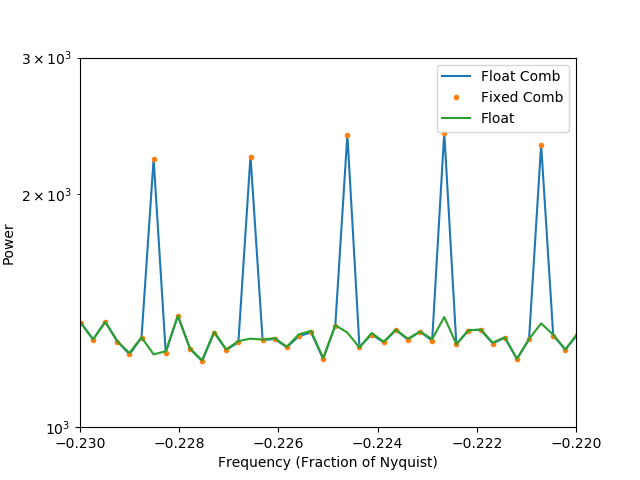

In [11]:
freq = np.fft.fftfreq(NCHAN)
_signal_power = np.average(np.abs(_signal)**2, axis=0)
_signal_comb_power = np.average(np.abs(_signal_comb)**2, axis=0)
_sig_power = np.average(_sig_real.astype(np.int64)**2 + _sig_imag.astype(np.int64)**2, axis=0)
plt.figure()
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_signal_comb_power), label='Float Comb')
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_sig_power), '.', label='Fixed Comb')
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_signal_power), label='Float')
plt.xlabel('Frequency (Fraction of Nyquist)')
plt.ylabel('Power')
plt.xlim(-0.23,-0.22)
plt.ylim(1e3, 3e3)
_ = plt.legend(loc='best')

So even though we are missing samples, the dominant effect is still to leak the DC done into other bins, adding "stalagmites", not "stalactites". Maybe we need to not have a tone to see a negative-power effect.

### Attempt 2: Input Comb, no DC tone

In [12]:
# Create a (floating-point) signal input
NTIMES = 1024
NSTAGES = 12
NCHAN = 2**NSTAGES
signal = (np.random.normal(size=(NTIMES,NCHAN)) + 1j * np.random.normal(size=(NTIMES,NCHAN))) # noise
# Create the comb
signal_comb = signal.copy()
signal_comb.shape = (NTIMES, -1, 8)
signal_comb[...,0] = 0
signal_comb.shape = (NTIMES, NCHAN)
# Digitize the input signal according to the specified fixed point type
fpt = fp_fft.FixedPointType(18, 17)
sig_real = fpt.from_float(signal_comb.real)
sig_imag = fpt.from_float(signal_comb.imag)

In [13]:
shifts = [1] * NSTAGES       # A sufficiently aggressive shift schedule
_signal = np.fft.fft(signal) * 2**fpt.bin_point / 2**sum(shifts)
_signal_comb = np.fft.fft(signal_comb) * 2**fpt.bin_point / 2**sum(shifts)
_sig_real, _sig_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts)

<IPython.core.display.Javascript object>


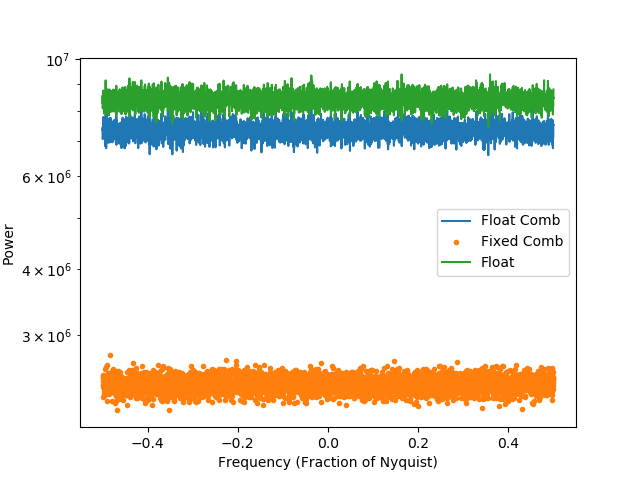

In [14]:
freq = np.fft.fftfreq(NCHAN)
_signal_power = np.average(np.abs(_signal)**2, axis=0)
_signal_comb_power = np.average(np.abs(_signal_comb)**2, axis=0)
_sig_power = np.average(_sig_real.astype(np.int64)**2 + _sig_imag.astype(np.int64)**2, axis=0)
plt.figure()
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_signal_comb_power), label='Float Comb')
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_sig_power), '.', label='Fixed Comb')
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_signal_power), label='Float')
plt.xlabel('Frequency (Fraction of Nyquist)')
plt.ylabel('Power')
_ = plt.legend(loc='best')

Well, it looks like here, we mostly just lost power across the band (no structure in the passband). We lost more power in the fixed-point FFT of the comb than in the float FFT, which is puzzling, but it's not the structure we were looking for, so let's keep moving.

### Attempt 3: Zeroing out an intermediate stage of the Fixed-Point FFT

What if there were a bug in the FFT that occasionally just zeroed out one of the nodes in the butterfly diagram? (note: I have no reason to expect this might be true). What would happen?

In [15]:
# Create a (floating-point) signal input
NTIMES = 1024
NSTAGES = 12
NCHAN = 2**NSTAGES
signal = (np.random.normal(size=(NTIMES,NCHAN)) + 1j * np.random.normal(size=(NTIMES,NCHAN))) # noise
# Digitize the input signal according to the specified fixed point type
fpt = fp_fft.FixedPointType(18, 17)
sig_real = fpt.from_float(signal.real)
sig_imag = fpt.from_float(signal.imag)

In [16]:
#shifts = [1] * NSTAGES                # Changing between these two shift schedules
shifts = [0, 1] * (NSTAGES // 2)       # Doesn't impact the icicles of death

# Begin hacked FFT
out_real, out_imag = sig_real, sig_imag
# Do all the butterflies
for stage in range(1, NSTAGES+1 - 3):
    out_real, out_imag = fp_fft.butterfly_r2(out_real, out_imag, stage, NSTAGES, fpt, fpt, fpt, True)

# Do the last three stages with a zeroing error
out1_real, out1_imag = out_real.copy(), out_imag.copy()
out1_real[...,2] = 0 # hack representing an internal FFT bug
out1_imag[...,2] = 0 # hack representing an internal FFT bug
out1_real, out1_imag = fp_fft.butterfly_r2(out1_real, out1_imag, NSTAGES-2, NSTAGES, fpt, fpt, fpt, True)
out_real, out_imag = fp_fft.butterfly_r2(out_real, out_imag, NSTAGES-2, NSTAGES, fpt, fpt, fpt, True)

out2_real, out2_imag = out_real.copy(), out_imag.copy()
out2_real[...,2] = 0 # hack representing an internal FFT bug
out2_imag[...,2] = 0 # hack representing an internal FFT bug
out2_real, out2_imag = fp_fft.butterfly_r2(out2_real, out2_imag, NSTAGES-1, NSTAGES, fpt, fpt, fpt, True)
out1_real, out1_imag = fp_fft.butterfly_r2(out1_real, out1_imag, NSTAGES-1, NSTAGES, fpt, fpt, fpt, True)
out_real, out_imag = fp_fft.butterfly_r2(out_real, out_imag, NSTAGES-1, NSTAGES, fpt, fpt, fpt, True)

out3_real, out3_imag = out_real.copy(), out_imag.copy()
out3_real[...,2] = 0 # hack representing an internal FFT bug
out3_imag[...,2] = 0 # hack representing an internal FFT bug
out3_real, out3_imag = fp_fft.butterfly_r2(out3_real, out3_imag, NSTAGES, NSTAGES, fpt, fpt, fpt, True)
out2_real, out2_imag = fp_fft.butterfly_r2(out2_real, out2_imag, NSTAGES, NSTAGES, fpt, fpt, fpt, True)
out1_real, out1_imag = fp_fft.butterfly_r2(out1_real, out1_imag, NSTAGES, NSTAGES, fpt, fpt, fpt, True)
out_real, out_imag = fp_fft.butterfly_r2(out_real, out_imag, NSTAGES, NSTAGES, fpt, fpt, fpt, True)

# Undo the bit-reversed ordering of output channels
unscramble = fp_fft.bit_reverse(np.arange(2**NSTAGES), NSTAGES)
_sig_real = out_real[...,unscramble]
_sig_imag = out_imag[...,unscramble]
_sig1_real = out1_real[...,unscramble]
_sig1_imag = out1_imag[...,unscramble]
_sig2_real = out2_real[...,unscramble]
_sig2_imag = out2_imag[...,unscramble]
_sig3_real = out3_real[...,unscramble]
_sig3_imag = out3_imag[...,unscramble]

<IPython.core.display.Javascript object>


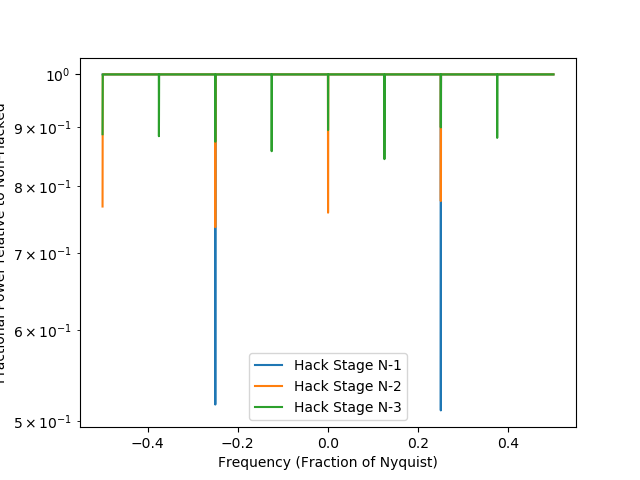

In [17]:
freq = np.fft.fftfreq(NCHAN)
_sig_power = np.average(_sig_real.astype(np.int64)**2 + _sig_imag.astype(np.int64)**2, axis=0)
_sig1_power = np.average(_sig1_real.astype(np.int64)**2 + _sig1_imag.astype(np.int64)**2, axis=0)
_sig2_power = np.average(_sig2_real.astype(np.int64)**2 + _sig2_imag.astype(np.int64)**2, axis=0)
_sig3_power = np.average(_sig3_real.astype(np.int64)**2 + _sig3_imag.astype(np.int64)**2, axis=0)
plt.figure()
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_sig3_power/_sig_power), label='Hack Stage N-1')
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_sig2_power/_sig_power), label='Hack Stage N-2')
plt.semilogy(np.fft.fftshift(freq), np.fft.fftshift(_sig1_power/_sig_power), label='Hack Stage N-3')
plt.xlabel('Frequency (Fraction of Nyquist)')
plt.ylabel('Fractional Power relative to Non-Hacked')
_ = plt.legend(loc='best')

Well that, at least, is something that looks like an icicly stalactite. Here's the thing: it doesn't change fractional amplitude with changes in the shift schedule, which is something that we know our real-life problem does. So this is a good start, but we need more.

### Attempt 4: Messing with Twiddles

Ok, time to get creative. Suppose the twiddle factors in the FFTs were a bit, hmm, screwy. If you zeroed one out, it might do something similar to what's above. But what if it were just a bit off in amplitude? (... And I'm just now realizing that with a bit-growth FFT like the HERA 3C correlator had, *fewer* bits of precision are probably being allocated to the twiddle coefficients, since they are magnitude-unity phase rotators, so this isn't a completely wacko idea). Could we get something that has a similar problem?

EDIT: After starting down this path, it became apparant that I could make an icicle-like behavior without messing with twiddles at all, just by comparing two different shift schedules.

In [105]:
shifts1 = [1] * NSTAGES
shifts2 = [0, 1] * (NSTAGES // 2)
signal = (np.random.normal(size=(NTIMES,NCHAN)) + 1j * np.random.normal(size=(NTIMES,NCHAN))) / 80 # noise
fpt = fp_fft.FixedPointType(18,17) # same as above, but making sure it's explicit here
_sig1_real, _sig1_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts1)
_sig2_real, _sig2_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts2)

<IPython.core.display.Javascript object>


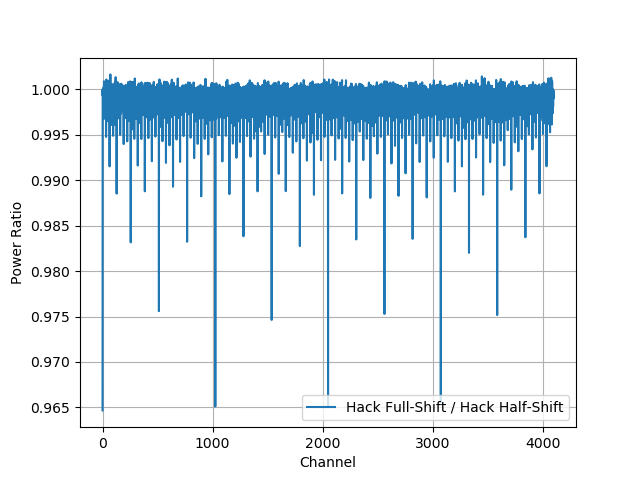

In [31]:
_sig1_power = np.average(_sig1_real.astype(np.int64)**2 + _sig1_imag.astype(np.int64)**2, axis=0) * 4**(sum(shifts1) - sum(shifts2))
_sig2_power = np.average(_sig2_real.astype(np.int64)**2 + _sig2_imag.astype(np.int64)**2, axis=0)

plt.figure()
plt.plot(_sig1_power/_sig2_power, label='Hack Full-Shift / Hack Half-Shift')
plt.xlabel('Channel')
plt.ylabel('Power Ratio')
plt.grid()
_ = plt.legend(loc='best')

#### Effects of Hermitian Folding

The HERA FFT uses a complex core to do two real-valued FFTs, separating the output spectra by doing a hermitial folding of the spectra. How does that affect the icicle pattern?

In [27]:
_sig1a_real = _sig1_real[...,1:NCHAN//2] + _sig1_real[...,:NCHAN//2:-1]
_sig1b_real = _sig1_real[...,1:NCHAN//2] - _sig1_real[...,:NCHAN//2:-1]
_sig1a_imag = _sig1_imag[...,1:NCHAN//2] - _sig1_imag[...,:NCHAN//2:-1]
_sig1b_imag = _sig1_imag[...,1:NCHAN//2] + _sig1_imag[...,:NCHAN//2:-1]
_sig2a_real = _sig2_real[...,1:NCHAN//2] + _sig2_real[...,:NCHAN//2:-1]
_sig2b_real = _sig2_real[...,1:NCHAN//2] - _sig2_real[...,:NCHAN//2:-1]
_sig2a_imag = _sig2_imag[...,1:NCHAN//2] - _sig2_imag[...,:NCHAN//2:-1]
_sig2b_imag = _sig2_imag[...,1:NCHAN//2] + _sig2_imag[...,:NCHAN//2:-1]

<IPython.core.display.Javascript object>


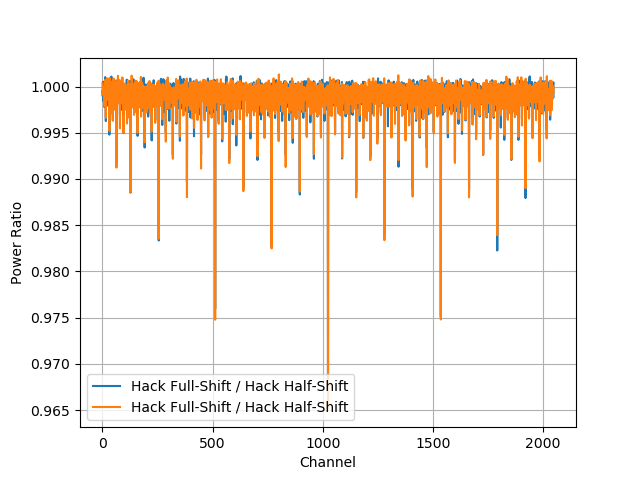

In [28]:
channel = range(1,NCHAN//2) # we dropped the DC channel in the folding
_sig1a_power = np.average(_sig1a_real.astype(np.int64)**2 + _sig1a_imag.astype(np.int64)**2, axis=0) * 4**(sum(shifts1) - sum(shifts2))
_sig1b_power = np.average(_sig1b_real.astype(np.int64)**2 + _sig1b_imag.astype(np.int64)**2, axis=0) * 4**(sum(shifts1) - sum(shifts2))
_sig2a_power = np.average(_sig2a_real.astype(np.int64)**2 + _sig2a_imag.astype(np.int64)**2, axis=0)
_sig2b_power = np.average(_sig2b_real.astype(np.int64)**2 + _sig2b_imag.astype(np.int64)**2, axis=0)
plt.figure()
plt.plot(channel, _sig1a_power/_sig2a_power, label='Hack Full-Shift / Hack Half-Shift')
plt.plot(channel, _sig1b_power/_sig2b_power, label='Hack Full-Shift / Hack Half-Shift')
plt.xlabel('Channel')
plt.ylabel('Power Ratio')
plt.grid()
_ = plt.legend(loc='best')

So whatever the issue is with the vanilla fixed-point FFT, it can introduce spikes at a variety of scales (though most pronounced at subdivisions of the band that are smaller powers of 2).  Could this be the icicle problem?

#### Migitation 1

My first guess is that these features have to do with finite bit widths in the twiddle factors. There are two ways this can happen: 1) round-off precision at the LSB of the twiddle factors (unlikely, because 17 bits after the binary point is a lot), or 2) the fact that for 18.17 numbers, we can't represent 1 (and for symmetry, we apply this to -1 as well) and so have to slightly clip the amplitude of those numbers.

Let's first try throwing more bits at the problem:

In [62]:
shifts1 = [1] * NSTAGES
shifts2 = [0, 1] * (NSTAGES // 2)
fpt_more = fp_fft.FixedPointType(24,23) # add more bits to twiddles
fpt_i = [fpt] + [fpt_more] * (NSTAGES-1)
fpt_o = [fpt_more] * NSTAGES
_sig1_real, _sig1_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt_i, fpt_o, fpt_more, shifts1)
_sig2_real, _sig2_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt_i, fpt_o, fpt_more, shifts2)

<IPython.core.display.Javascript object>


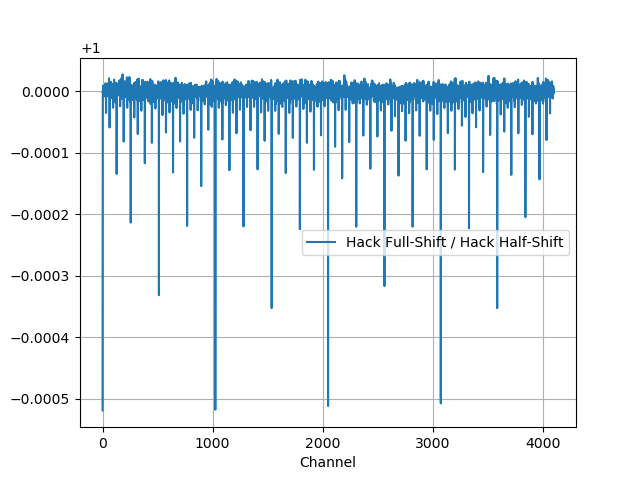

In [63]:
_sig1_power = np.average(_sig1_real.astype(np.int64)**2 + _sig1_imag.astype(np.int64)**2, axis=0) * 4**(sum(shifts1) - sum(shifts2))
_sig2_power = np.average(_sig2_real.astype(np.int64)**2 + _sig2_imag.astype(np.int64)**2, axis=0)

plt.figure()
plt.plot(_sig1_power/_sig2_power, label='Hack Full-Shift / Hack Half-Shift')
plt.xlabel('Channel')
plt.ylabel('Power Ratio')
plt.grid()
_ = plt.legend(loc='best')

So adding 6 bits across the board (going from 18.17 to 24.23) reduced the fractional icicle depth from -0.045
to -0.0005 (a factor of 90), which is more than the factor of $2^6$ that I would have expected. So number of bits definitely affects icicles, but not by the expected factor.

#### Mitigation 2

Is it possible that the clipping of the twiddle factors to avoid 1/-1 is causing this? We could tweak the clipping to see...

In [82]:
real_twiddle = fp_fft.twiddle_r2 # save for later if doing monkey patches

In [111]:
def hack_twiddle(stage, stages, fptype):
    assert(fptype.bit_width >= fptype.bin_point + 2) # ensure we can represent +/- 1
    ind = np.arange(2**(stages-1), dtype=np.int32)
    ind = fp_fft.bit_reverse(ind >> (stages - stage), stage-1)
    theta = -np.pi * fp_fft.FixedPointType(stage, stage-1).to_float(ind)
    tw_real = np.cos(theta)
    tw_imag = np.sin(theta)
    tw_real = fptype.from_float(tw_real) # removed clipping
    tw_imag = fptype.from_float(tw_imag) # removed clipping
    tw_amp = np.abs(fptype.to_float(tw_real)+1j*fptype.to_float(tw_imag))
    return tw_real, tw_imag

fp_fft.twiddle_r2 = hack_twiddle # monkey patch

shifts1 = [1] * NSTAGES
shifts2 = [0, 1] * (NSTAGES // 2)
fpt = fp_fft.FixedPointType(18,17)
fpt_tw = fp_fft.FixedPointType(19,17)
#fpt_tw = fp_fft.FixedPointType(32,30) # throwing more bits at the twiddle doesn't help
_sig1_real, _sig1_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt_tw, shifts1)
_sig2_real, _sig2_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt_tw, shifts2)

fp_fft.twiddle_r2 = real_twiddle # undo monkey patch

<IPython.core.display.Javascript object>


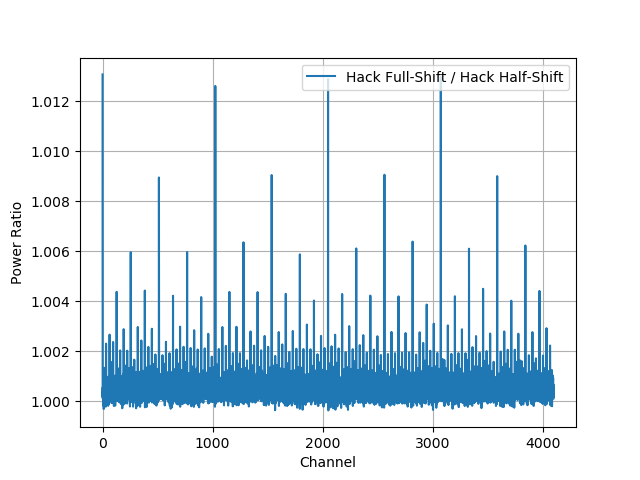

In [112]:
_sig1_power = np.average(_sig1_real.astype(np.int64)**2 + _sig1_imag.astype(np.int64)**2, axis=0) * 4**(sum(shifts1) - sum(shifts2))
_sig2_power = np.average(_sig2_real.astype(np.int64)**2 + _sig2_imag.astype(np.int64)**2, axis=0)

plt.figure()
plt.plot(_sig1_power/_sig2_power, label='Hack Full-Shift / Hack Half-Shift')
plt.xlabel('Channel')
plt.ylabel('Power Ratio')
plt.grid()
_ = plt.legend(loc='best')

Didn't see that coming. Apparently using un-clipped twiddles makes the spikes go up, but at the same amplitude? Weird. I don't know what to make of this.

#### Mitigation 3

To what extent does signal level factor into all of this? Let's increase the signal level and see.

In [113]:
# Create a (floating-point) signal input
NTIMES = 1024
NSTAGES = 12
NCHAN = 2**NSTAGES
#signal = (np.random.normal(size=(NTIMES,NCHAN)) + 1j * np.random.normal(size=(NTIMES,NCHAN)))/80 # noise
bigger_signal = (np.random.normal(size=(NTIMES,NCHAN)) + 1j * np.random.normal(size=(NTIMES,NCHAN)))/20 # noise
# Digitize the input signal according to the specified fixed point type
fpt = fp_fft.FixedPointType(18, 17)
big_real = fpt.from_float(bigger_signal.real)
big_imag = fpt.from_float(bigger_signal.imag)

In [114]:
shifts1 = [1] * NSTAGES
shifts2 = [0, 1] * (NSTAGES // 2)
_sig1_real, _sig1_imag = fp_fft.fft_r2(big_real, big_imag, NSTAGES, fpt, fpt, fpt, shifts1)
_sig2_real, _sig2_imag = fp_fft.fft_r2(big_real, big_imag, NSTAGES, fpt, fpt, fpt, shifts2)

<IPython.core.display.Javascript object>


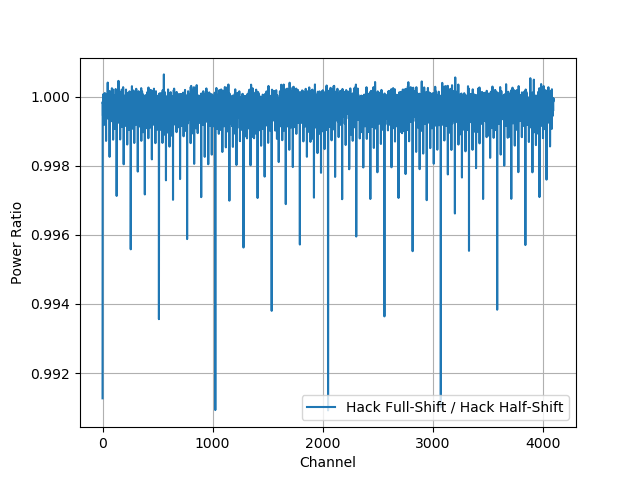

In [115]:
_sig1_power = np.average(_sig1_real.astype(np.int64)**2 + _sig1_imag.astype(np.int64)**2, axis=0) * 4**(sum(shifts1) - sum(shifts2))
_sig2_power = np.average(_sig2_real.astype(np.int64)**2 + _sig2_imag.astype(np.int64)**2, axis=0)

plt.figure()
plt.plot(_sig1_power/_sig2_power, label='Hack Full-Shift / Hack Half-Shift')
plt.xlabel('Channel')
plt.ylabel('Power Ratio')
plt.grid()
_ = plt.legend(loc='best')

Ah, so increasing the signal level *does* reduce the fractional amplitude of spikes. This and the result that increasing the bits reduces reduces spikes makes it pretty certain that this is a round-off effect, and it has something to do with twiddles because messing with them can change the direction of the spikes. So we are getting closer, but I'm still not sure how to fix it.

#### Mitigation 4

What if we don't shift? This is the "bit-growth" FFT approach. In this case, I'll need an absolute (floating-point) reference, so first, let's see if I can see the spikes using a ratio with the numpy fft:

In [126]:
_sig1_real, _sig1_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts1)
_sig2_real, _sig2_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts2)

<IPython.core.display.Javascript object>


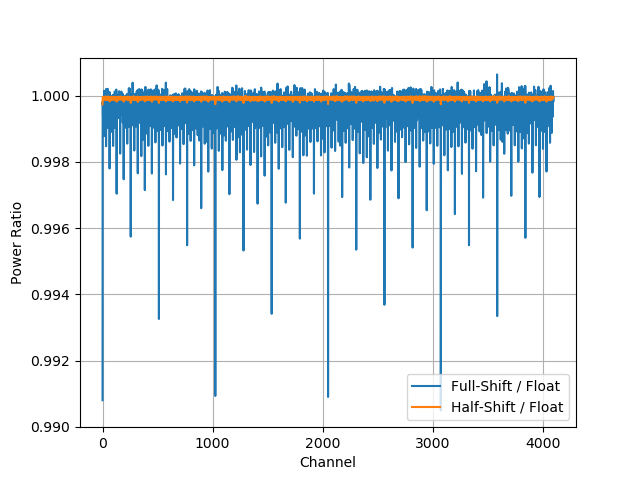

In [131]:
# to get the float fft accurate enough for comparison to the fp-fft, 
# we have to use the quantized input, converted back to floats
_signal = np.fft.fft(fpt.to_float(sig_real) + 1j * fpt.to_float(sig_imag))
_sig1_power = np.average(_sig1_real.astype(np.int64)**2 + _sig1_imag.astype(np.int64)**2, axis=0) * 4**(sum(shifts1) - sum(shifts2))
_sig2_power = np.average(_sig2_real.astype(np.int64)**2 + _sig2_imag.astype(np.int64)**2, axis=0)
_sig_power = np.average(np.abs(_signal)**2, axis=0) * 4**fpt.bin_point / 4**sum(shifts2)

plt.figure()
#plt.plot(_sig1_power/_sig2_power, label='Full-Shift / Float')
plt.plot(_sig1_power/_sig_power, label='Full-Shift / Float')
plt.plot(_sig2_power/_sig_power, label='Half-Shift / Float')
plt.xlabel('Channel')
plt.ylabel('Power Ratio')
plt.grid()
_ = plt.legend(loc='best')

Great. Now we can see if no shifting results in icicles:

In [140]:
fpt = fp_fft.FixedPointType(18,17)
fpt32 = fp_fft.FixedPointType(32,17) # need enough bits to not overflow
sig3_real = fpt32.cast(sig_real, fpt)
sig3_imag = fpt32.cast(sig_imag, fpt)
_sig3_real, _sig3_imag = fp_fft.fft_r2(sig3_real, sig3_imag, NSTAGES, fpt32, fpt32, fpt, [0] * NSTAGES)

<IPython.core.display.Javascript object>


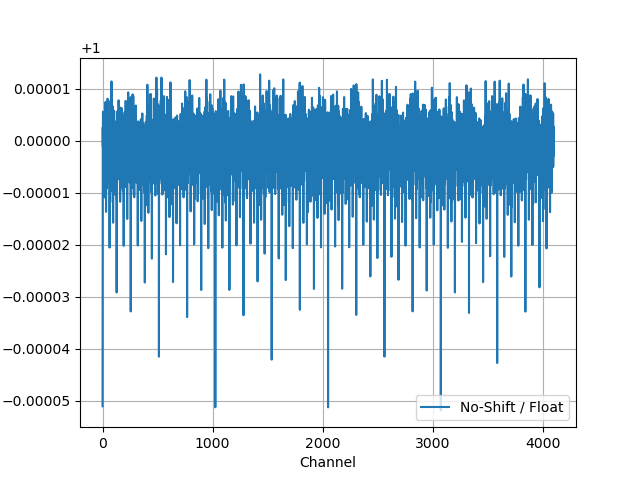

In [141]:
_sig_power = np.average(np.abs(_signal)**2, axis=0) * 4**fpt.bin_point
_sig3_power = np.average(_sig3_real.astype(np.int64)**2 + _sig3_imag.astype(np.int64)**2, axis=0)

plt.figure()
plt.plot(_sig3_power/_sig_power, label='No-Shift / Float')
plt.xlabel('Channel')
plt.ylabel('Power Ratio')
plt.grid()
_ = plt.legend(loc='best')

Hmph. So spikes are there, even without shifting, albeit at a lower level.

In [19]:
# Create a (floating-point) signal input
NTIMES = 2048
NSTAGES = 12
NCHAN = 2**NSTAGES
signal = (np.random.normal(size=(NTIMES,NCHAN)) + 1j * np.random.normal(size=(NTIMES,NCHAN))) / 80 # noise
# Digitize the input signal according to the specified fixed point type
fpt = fp_fft.FixedPointType(18, 17)
sig_real = fpt.from_float(signal.real)
sig_imag = fpt.from_float(signal.imag)

In [20]:
# As a first shot, what if we just drastically reduce the precision of our twiddle coefficients?
fpt_tw = fp_fft.FixedPointType(6,5)
shifts1 = [1] * NSTAGES                #
shifts2 = [0, 1] * (NSTAGES // 2)       #
_sig1_real, _sig1_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt_tw, shifts1)
_sig2_real, _sig2_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt_tw, shifts2)

<IPython.core.display.Javascript object>


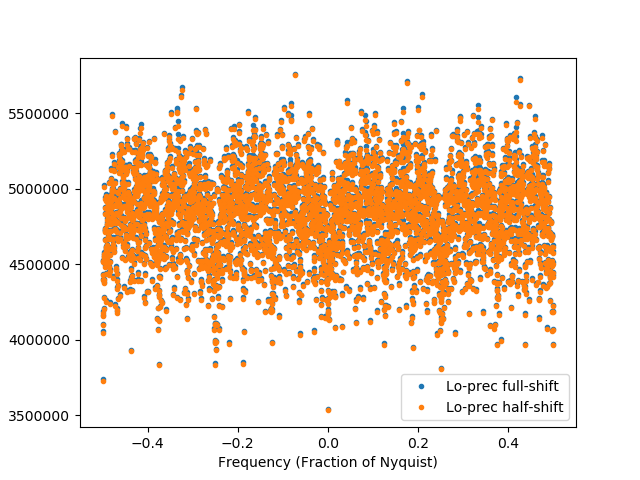

In [21]:
freq = np.fft.fftfreq(NCHAN)
_sig1_power = np.average(_sig1_real.astype(np.int64)**2 + _sig1_imag.astype(np.int64)**2, axis=0) * 4**(sum(shifts1) - sum(shifts2))
_sig2_power = np.average(_sig2_real.astype(np.int64)**2 + _sig2_imag.astype(np.int64)**2, axis=0)
plt.figure()
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(_sig1_power), '.', label='Lo-prec full-shift')
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(_sig2_power), '.', label='Lo-prec half-shift')
plt.xlabel('Frequency (Fraction of Nyquist)')
plt.ylabel('Power')
_ = plt.legend(loc='best')

So it looks like poor bit resolution in twiddle factors can put dips (I hesitate to call these "icicles") in the passband, but I still can't reproduce the shift behavior. What if we get a bit more... invasive?

In [22]:
def hack_twiddle(stage, stages, fptype):
    ind = np.arange(2**(stages-1), dtype=np.int32)
    ind = fp_fft.bit_reverse(ind >> (stages - stage), stage-1)
    theta = -np.pi * fp_fft.FixedPointType(stage, stage-1).to_float(ind)
    tw_real = np.cos(theta)
    tw_imag = np.sin(theta)
    #mx = (2**(fptype.bit_width-1) - 1) / 2**(fptype.bit_width-1)
    mx = (2**(fptype.bit_width-1) - 2**(fptype.bit_width-4)) / 2**(fptype.bit_width-1) # square off twiddles close to real/imag axes
    tw_real = fptype.from_float(tw_real.clip(-mx,mx))
    tw_imag = fptype.from_float(tw_imag.clip(-mx,mx))
    return tw_real, tw_imag

#fp_fft.twiddle_r2 = hack_twiddle # monkey patch

shifts1 = [1] * NSTAGES
shifts2 = [0, 1] * (NSTAGES // 2)
_sig1_real, _sig1_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts1)
_sig2_real, _sig2_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts2)

fp_fft.twiddle_r2 = real_twiddle # undo monkey patch

<IPython.core.display.Javascript object>


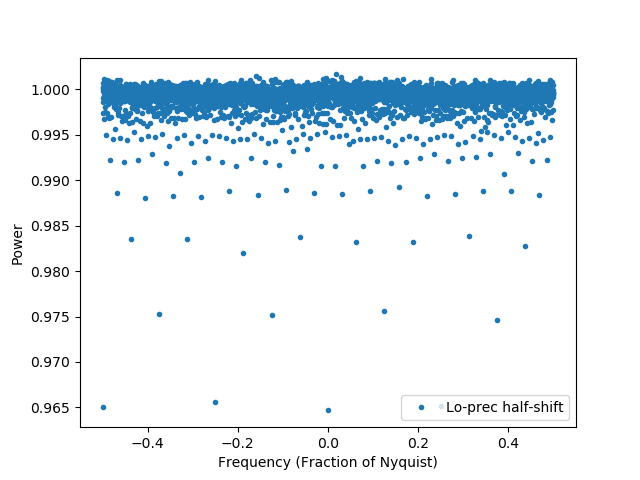

In [29]:
freq = np.fft.fftfreq(NCHAN)
_sig1_power = np.average(_sig1_real.astype(np.int64)**2 + _sig1_imag.astype(np.int64)**2, axis=0) * 4**(sum(shifts1) - sum(shifts2))
_sig2_power = np.average(_sig2_real.astype(np.int64)**2 + _sig2_imag.astype(np.int64)**2, axis=0)
plt.figure()
#plt.plot(np.fft.fftshift(freq), np.fft.fftshift(_sig1_power), '.', label='Lo-prec full-shift')
#plt.plot(np.fft.fftshift(freq), np.fft.fftshift(_sig2_power), '.', label='Lo-prec half-shift')
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(_sig1_power/_sig2_power), '.', label='Lo-prec half-shift')
plt.xlabel('Frequency (Fraction of Nyquist)')
plt.ylabel('Power')
_ = plt.legend(loc='best')

Hmm. This hack looks a lot like just reducing the bit precision of the twiddle factors, and still no shift dependence.  What if we just pick a coefficient and screw it up systematically?

In [24]:
def hack_twiddle2(stage, stages, fptype):
    ind = np.arange(2**(stages-1), dtype=np.int32)
    ind = fp_fft.bit_reverse(ind >> (stages - stage), stage-1)
    theta = -np.pi * fp_fft.FixedPointType(stage, stage-1).to_float(ind)
    tw_real = np.cos(theta)
    tw_imag = np.sin(theta)
    # picking thetas where the full magnitude of the twiddle is along imag axis -> spikes every 32ch (16 after folding)
    #tw_imag = np.where(np.abs(theta + np.pi/2) < 1e-5, tw_imag / 2, tw_imag) # screw up one theta
    
    # picking two thetas and reducing amplitude by 2 -> spikes every 16ch (8 after folding)
    tw_real = np.where(np.abs(theta + 3*np.pi/4) < 1e-5, 1*tw_real / 1, tw_real) #
    tw_imag = np.where(np.abs(theta + 3*np.pi/4) < 1e-5, 1*tw_imag / 1, tw_imag) #
    tw_real = np.where(np.abs(theta + 1*np.pi/4) < 1e-5, 1*tw_real / 1, tw_real) #
    tw_imag = np.where(np.abs(theta + 1*np.pi/4) < 1e-5, 1*tw_imag / 1, tw_imag) #
    
    # pick 2 thetas unevenly split around -pi/2 -> same as above, slight change in phase of small spikes
    #tw_real = np.where(np.abs(theta + 5*np.pi/8) < 1e-5, tw_real / 2, tw_real) #
    #tw_imag = np.where(np.abs(theta + 5*np.pi/8) < 1e-5, tw_imag / 2, tw_imag) #
    #tw_real = np.where(np.abs(theta + 3*np.pi/8) < 1e-5, tw_real / 2, tw_real) #
    #tw_imag = np.where(np.abs(theta + 3*np.pi/8) < 1e-5, tw_imag / 2, tw_imag) #
    
    mx = (2**(fptype.bit_width-1) - 1) / 2**(fptype.bit_width-1)
    tw_real = fptype.from_float(tw_real.clip(-mx,mx))
    tw_imag = fptype.from_float(tw_imag.clip(-mx,mx))
    return tw_real, tw_imag

#fp_fft.twiddle_r2 = hack_twiddle2 # monkey patch

shifts1 = [1] * NSTAGES
shifts2 = [0, 1] * (NSTAGES // 2)
_sig1_real, _sig1_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts1)
_sig2_real, _sig2_imag = fp_fft.fft_r2(sig_real, sig_imag, NSTAGES, fpt, fpt, fpt, shifts2)

fp_fft.twiddle_r2 = real_twiddle # undo monkey patch

<IPython.core.display.Javascript object>


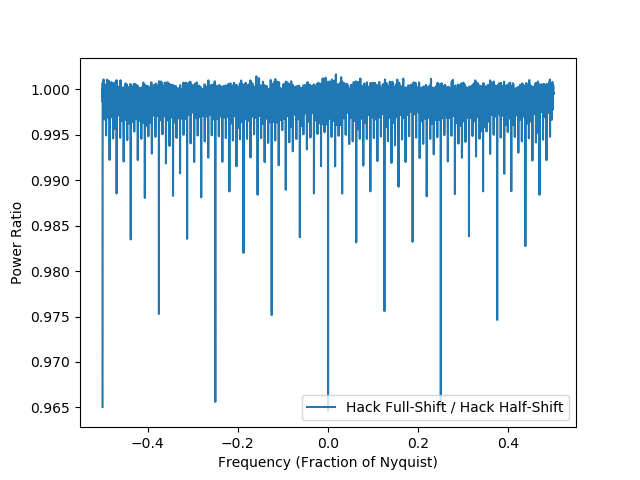

In [25]:
freq = np.fft.fftfreq(NCHAN)
_sig1_power = np.average(_sig1_real.astype(np.int64)**2 + _sig1_imag.astype(np.int64)**2, axis=0) * 4**(sum(shifts1) - sum(shifts2))
_sig2_power = np.average(_sig2_real.astype(np.int64)**2 + _sig2_imag.astype(np.int64)**2, axis=0)
plt.figure()
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(_sig1_power/_sig2_power), label='Hack Full-Shift / Hack Half-Shift')
plt.xlabel('Frequency (Fraction of Nyquist)')
plt.ylabel('Power Ratio')
_ = plt.legend(loc='best')

Interesting! This hack has a lot of features of the real problem. There's a periodicity to the icicles, but a lot of substructure. It's worse for the FFT with more shifting (shown above is a ratio of full-shift to half-shift).

<IPython.core.display.Javascript object>


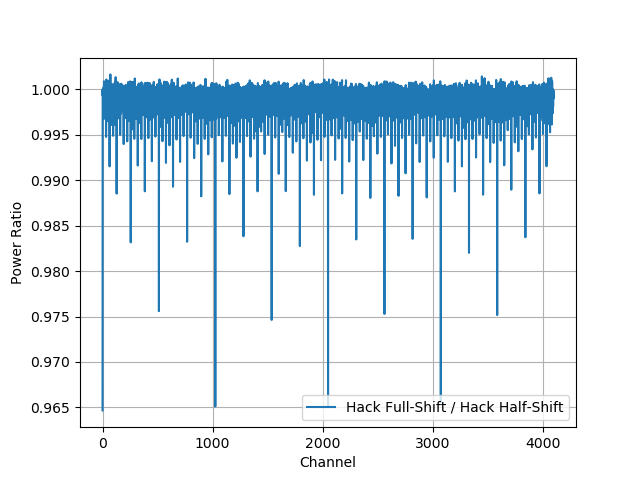

In [26]:
plt.figure()
plt.plot(_sig1_power/_sig2_power, label='Hack Full-Shift / Hack Half-Shift')
plt.xlabel('Channel')
plt.ylabel('Power Ratio')
plt.grid()
_ = plt.legend(loc='best')